In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings


def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

working dir is '/Users/hemker konstantin/Documents/repos/Facet/facet'
added `/Users/hemker konstantin/Documents/repos/Facet/pytools/src` to python paths
added `/Users/hemker konstantin/Documents/repos/Facet/facet/src` to python paths
added `/Users/hemker konstantin/Documents/repos/Facet/sklearndf/src` to python paths


# Imports

Conventional imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Gamma Facet imports

In [3]:
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

Sklearndf imports

Instead of using the "regular" scikit-learn package, we are using the `sklearndf` (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) wrapper which keeps metadata such as column names when passing the data through the scikit-learn learners.  

In [4]:
# sklearndf
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF


The sklearn.linear_model.stochastic_gradient module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.


In [5]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

In [ ]:
# this
from sklearn.pipeline import Pipeline
# becomes this
from sklearndf.pipeline import PipelineDF

In [32]:
from facet import Sample
import pandas as pd
from sklearndf.pipeline import PipelineDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.transformation import SimpleImputerDF

In [7]:
data_root = Path("sphinx/source/tutorial/")
df = pd.read_csv(data_root.joinpath("water_drill_data.csv"), sep=";", encoding="utf-8")

In [8]:
# Sample
sample = Sample(observations=df, target="Failure likelihood (%)")

In [33]:
# Wrapper class to implement Boruta feature selection
boruta = BorutaDF(
    estimator = RandomForestRegressorDF(max_depth=5, random_state=42, n_jobs=3), 
    n_estimators="auto",  
    random_state=42, 
    verbose=0, 
    max_iter=100
)

preprocessing_pipeline = PipelineDF(
    steps = [
        ("impute", SimpleImputerDF()),
        ("feature selection", boruta)
    ]

)

preprocessing_pipeline.fit(X=sample.features, y=sample.target)

print(f"Selected features: {list(preprocessing_pipeline.features_out)}")
sample_selected = sample.keep(preprocessing_pipeline.features_out)

Selected features: ['Weight on bit (kg)', 'Drill rate (m/s)', 'Vertical depth of operation (m)', 'Mud density (kg/m3)', 'Nonlinear1', 'Bit depth (m)']


We can see that the key features that we would expect to effect the safety of the operation would are still being included after the feature selection. A working hypothesis of how these influence the target are: 
- **Weight on bit**: we expect higher weight to increase the likelihood of a failure due to heavier equipment wear
- **Drill rate**: similarly to the above, a higher drill rate leads to more wear & tear of the equipment and thus we expect a positive effect
- **Vertical depth of operation**: the deeper we dig, the more dense we expect the soil to be that we need to dig through, increasing the likelihood of either a collapse or equipment wear
- **Bit depth**: Should contain similar information to the vertical depth of the operation

# Cross validation

We will use a simple Bootstrap for the time series analysis here. Note that if we were given a time series dataset here (i.e. if we had timestamps of the GT readings) we could use a stationary bootstrap here using `StationaryBootstrapCV`)

# Regressor Pipeline

In [34]:
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV

In [16]:
cv = BootstrapCV(n_splits=10, random_state=42)

rf_pipeline = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(n_estimators=500, random_state=42),
)

lgbm_pipeline = RegressorPipelineDF(
    regressor=LGBMRegressorDF(random_state=42),
)


grid = [
    LearnerGrid(
        pipeline=rf_pipeline, 
        learner_parameters={ 
            "min_samples_leaf": [8, 11, 15]
        } 
        ),
    LearnerGrid(
        pipeline=lgbm_pipeline, 
        learner_parameters={ 
            "min_data_in_leaf": [8, 11, 15]
        }
    )
]

In [17]:
ranker = LearnerRanker( 
    grids=grid, cv=cv, n_jobs=-3
).fit(sample=sample_selected)

In [18]:
ranker.best_model

RegressorPipelineDF(regressor=LGBMRegressorDF(min_data_in_leaf=8,
                                              random_state=42))

In [19]:
print(ranker.summary_report())

Rank  1:         LGBMRegressorDF, ranking_score=    0.923, scores_mean=    0.948, scores_std=   0.0126, parameters={regressor__min_data_in_leaf=8}

Rank  2:         LGBMRegressorDF, ranking_score=    0.915, scores_mean=    0.942, scores_std=   0.0137, parameters={regressor__min_data_in_leaf=11}

Rank  3:         LGBMRegressorDF, ranking_score=    0.903, scores_mean=    0.934, scores_std=   0.0156, parameters={regressor__min_data_in_leaf=15}

Rank  4: RandomForestRegressorDF, ranking_score=    0.868, scores_mean=    0.908, scores_std=   0.0196, parameters={regressor__min_samples_leaf=8}

Rank  5: RandomForestRegressorDF, ranking_score=    0.856, scores_mean=    0.894, scores_std=   0.0191, parameters={regressor__min_samples_leaf=11}

Rank  6: RandomForestRegressorDF, ranking_score=    0.832, scores_mean=    0.877, scores_std=   0.0224, parameters={regressor__min_samples_leaf=15}



# Model inspection

In [20]:
inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit)

In [21]:
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()

#### Feature redundancy

When plotting out the feature redundancy, we can see that there are some features which contain the same information to the model. In this case, these features are the vertical depth of the operation and the bit depth. 
Intuitively, we can see why these two features are redundant, as the bit depth will be in its most critical stages when it is drilling, i.e. at the vertical depth of operation. 

As we don't want either of the features to confuse the model inference during the simulation step, we should remove the bit depth for this example.

In [ ]:
from facet.inspection import LearnerInspector

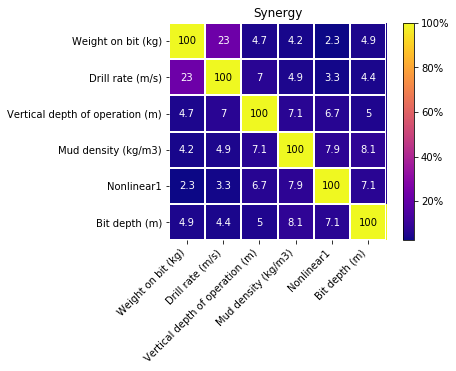

In [35]:
inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit)

synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

In [ ]:
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

In [ ]:
redundant_features = ["Bit depth [m]"]
sample_selected = sample_selected.drop(redundant_features)

#### Feature synergy
When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the weight on the bit and the drill rate in combination appear to have a high synergy. 

In hindsight, this appears obvious - drilling with both high bit weight and a high pace can have a disproportionally large impact on the wear of the equipment.

In [ ]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

In [ ]:
synergy_matrix

# Simulation

From the synergy matrix, we can see that the Compressor outlet temperature has the highest synergy with most other features. Therefore, we would want to see how the target behaves if we simulate this feature such that each state had a constant outlet compressor temperature. 

First of all, let's see if this is also confirmed by the SHAP feature importances. 

In [ ]:
feat_importance = synergy_matrix.sum(axis=0).reset_index().rename({0: "Total Synergies"}, axis=1)
feat_importance["Total Synergies"] -= 1

In [ ]:
feat_importance.sort_values(by="Total Synergies", ascending=False)

We can see that the strong synergies with all other features of the Compressor outlet air temperature is also visible in the aboslute SHAP values. 

In [ ]:
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)

In [ ]:
cont_partitioner = ContinuousRangePartitioner()

In [ ]:
SIM_FEATURE = 'Weight on bit (kg)'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = cont_partitioner)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)

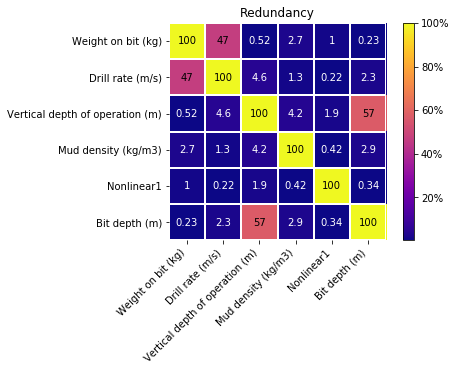

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)

In [23]:
redundant_features = ["Bit depth [m]"]
sample_selected = sample_selected.drop(redundant_features)

#### Feature synergy
When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the weight on the bit and the drill rate in combination appear to have a high synergy. 

In hindsight, this appears obvious - drilling with both high bit weight and a high pace can have a disproportionally large impact on the wear of the equipment.

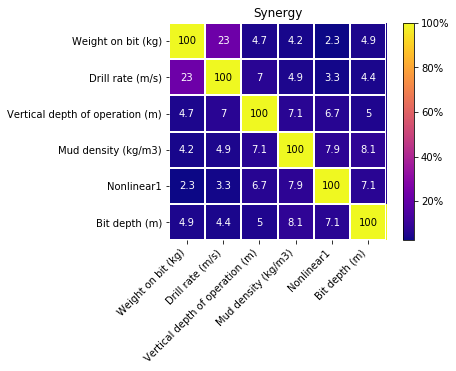

In [24]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

In [25]:
synergy_matrix

feature,Weight on bit (kg),Drill rate (m/s),Vertical depth of operation (m),Mud density (kg/m3),Nonlinear1,Bit depth (m)
feature,,,,,,
Weight on bit (kg),1.000000,0.228590,0.047436,0.042117,0.023487,0.049195
Drill rate (m/s),0.228590,1.000000,0.069802,0.048652,0.032936,0.044492
Vertical depth of operation (m),0.047436,0.069802,1.000000,0.071369,0.067288,0.050473
Mud density (kg/m3),0.042117,0.048652,0.071369,1.000000,0.079053,0.081128
Nonlinear1,0.023487,0.032936,0.067288,0.079053,1.000000,0.070590
Bit depth (m),0.049195,0.044492,0.050473,0.081128,0.070590,1.000000


# Simulation

From the synergy matrix, we can see that the Compressor outlet temperature has the highest synergy with most other features. Therefore, we would want to see how the target behaves if we simulate this feature such that each state had a constant outlet compressor temperature. 

First of all, let's see if this is also confirmed by the SHAP feature importances. 

In [26]:
feat_importance = synergy_matrix.sum(axis=0).reset_index().rename({0: "Total Synergies"}, axis=1)
feat_importance["Total Synergies"] -= 1

In [27]:
feat_importance.sort_values(by="Total Synergies", ascending=False)

,feature,Total Synergies
1,Drill rate (m/s),0.424472
0,Weight on bit (kg),0.390824
3,Mud density (kg/m3),0.322319
2,Vertical depth of operation (m),0.306369
5,Bit depth (m),0.295878
4,Nonlinear1,0.273354


We can see that the strong synergies with all other features of the Compressor outlet air temperature is also visible in the aboslute SHAP values. 

In [28]:
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)

In [38]:
cont_partitioner = ContinuousRangePartitioner()

In [39]:
SIM_FEATURE = 'Weight on bit (kg)'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = cont_partitioner)

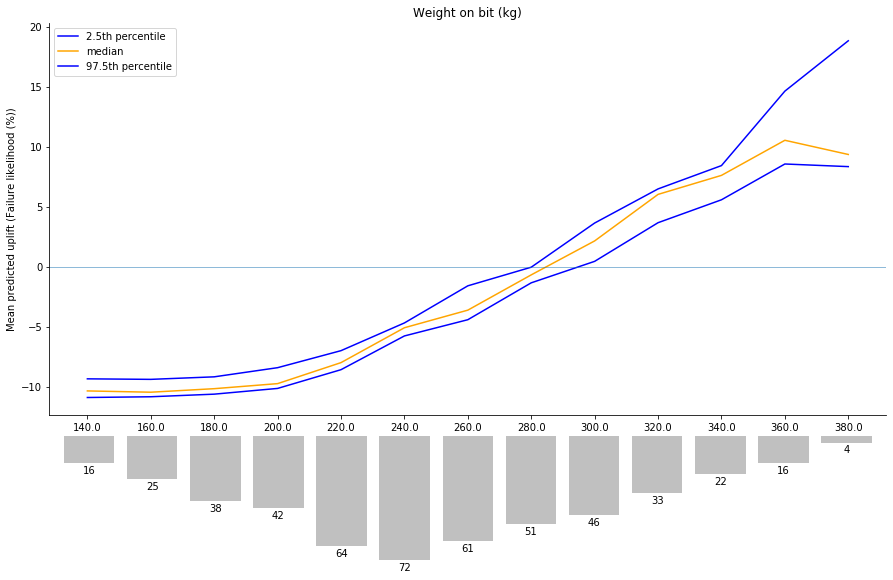

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)